<a href="https://colab.research.google.com/github/heminminmin/AI_Papering_Defects_Project/blob/main/b1_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!unzip '/content/drive/MyDrive/open.zip'

In [ ]:


gugu=[]

for i in range(1, 9, 1): 
  #print(i+2)
    for j in range(0,9,1) :
     print((j+1)*(i+1))

gugu.append((j+1)*(i+1))


2
4
6
8
10
12
14
16
18
3
6
9
12
15
18
21
24
27
4
8
12
16
20
24
28
32
36
5
10
15
20
25
30
35
40
45
6
12
18
24
30
36
42
48
54
7
14
21
28
35
42
49
56
63
8
16
24
32
40
48
56
64
72
9
18
27
36
45
54
63
72
81
81


In [ ]:
 gugu

[None]

In [ ]:
import os
from tensorflow.keras.utils import to_categorical

# ======== 학습 시킬 모든 이미지 파일들의 경로에 대한 리스트와 라벨 데이터 리스트 생성하기 ========

# c:\Users\UserK\Desktop\hansol_J\jiwon_work\..\..\open\train
TRAIN_FOLDER_PATH = os.path.join(os.getcwd(), os.pardir, os.pardir, 'open', 'train')
TRAIN_FOLDER_PATH = '/content/train/'
# print('TRAIN_FOLDER_PATH : ', TRAIN_FOLDER_PATH)

def get_train_image_paths_and_labels_fn():

    defect_types = os.listdir(TRAIN_FOLDER_PATH)
    # print('defect_types :', defect_types)

    labels = []
    train_image_paths = []

    for defect_type in defect_types:

        file_names = os.listdir(os.path.join(TRAIN_FOLDER_PATH, defect_type))
        # print('file_names: ', file_names)

        for file_name in file_names:
            train_image_paths.append(os.path.join(TRAIN_FOLDER_PATH, defect_type, file_name))
            labels.append(defect_type)

    # ====================== 라벨 정규화 과정 ======================
        # 문자열 형태의 범주형 데이터인 라벨 데이터를 정수 형태로 정규화
        normalized_labels = []

        # 추후에 라벨이 추가될 경우 등 확장성 및 모델의 안정성을 고려하여 총 19가지의 하자 유형의 순서가 변경되지 않도록 직접적으로 리스트 생성
        DEFECT_TYPE_NAMES = ["가구수정", "걸레받이수정", "곰팡이", "꼬임", "녹오염", "들뜸", "면불량", "몰딩수정", "반점", "석고수정",
                            "오염", "오타공", "울음", "이음부불량", "창틀,문틀수정", "터짐", "틈새과다", "피스", "훼손"]

        defect_type_count = len(DEFECT_TYPE_NAMES)

        for label in labels:
            normalized_labels.append(DEFECT_TYPE_NAMES.index(label))

        # [ 0, 0, 0, ... ]
        # print('normalized_labels :', normalized_labels)

        # 정수형 클래스의 레이블을 이진 클래스의 원핫 인코딩 벡터로 변환
        encoding_labels = to_categorical(normalized_labels, defect_type_count)
        print('encoding_labels.shape :', encoding_labels.shape)

  # =============================================================

        return train_image_paths, encoding_labels

# [ 하자 유형에 대한 폴더명\\파일명.확장자, ... ]
# print('train_image_paths: ', train_image_paths)

# [ 하자 유형에 대한 폴더명, ... ]
# print('labels :', labels)
    

In [ ]:
img_paths, labels = get_train_image_paths_and_labels_fn()

encoding_labels.shape : (1405, 19)


In [ ]:
from tensorflow.keras.preprocessing import image as keras_image
import tensorflow as tf
import numpy as np

# 객체 순회 및 진행률 표시 용도
# pip3 install tqdm
from tqdm import tqdm
def process_images(image, resized_width, resized_height):
    # 반대
    image = tf.image.flip_left_right(image)
    # random brightness -0.2~.2 
    image = tf.image.random_brightness(image, max_delta=0.2)
    # 정규화
    image = tf.image.per_image_standardization(image)
    
    image = tf.image.resize(image, (240,240))
    return image

    #tf.image.flip_left_right(), tf.image.flip_up_down(), tf.image.rot90(), tf.image.central_crop(), tf.image.crop_and_resize()


def get_tensor_through_imgs_fn(img_paths, resized_width, resized_height):

    list_of_tensors = []

    # 3457개의 이미지 데이터
    for img_path in tqdm(img_paths):

      
        img = keras_image.load_img(img_path)

        # <PIL.PngImagePlugin.PngImageFile image mode=RGB size=629x658 at 0x1BA13D4F790>
        # print('img :', img)

        # 원본 이미지
        x = keras_image.img_to_array(img)
        # print('x :', x.shape)
        
        normalized_x = process_images(x, resized_width, resized_height) / 255

        list_of_tensors.append(normalized_x)
        
    # print(list_of_tensors)
    return np.array(list_of_tensors, dtype=float)


In [ ]:
img_tensor = get_tensor_through_imgs_fn(img_paths, 240,240 )

100%|██████████| 1405/1405 [00:35<00:00, 39.61it/s]


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (img_tensor, labels))

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
print("Training data size:", train_ds_size)

train_ds = (train_ds
            .shuffle(buffer_size=train_ds_size)
            .batch(batch_size=32, drop_remainder=True)) #


Training data size: 1405


In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(32, 240, 240, 3), dtype=tf.float64, name=None), TensorSpec(shape=(32, 19), dtype=tf.float32, name=None))>

In [ ]:
def round_repeats(repeats, depth_coefficient):
    return int(math.ceil(depth_coefficient * repeats))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
import sys
from PIL import ImageFile
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import EfficientNetB1



In [ ]:

model=Sequential()
model.add(EfficientNetB1(input_shape=(240, 240, 3), include_top=False, weights=None))
model.add(Flatten())
model.add(Dense(19, activation='softmax'))


In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

import math

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
#net = keras.applications.EfficientNetB1()

32148312/32148312 [==============================] - 3s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
               loss='categorical_crossentropy', metrics=['acc'])


In [ ]:
train_history = model.fit(train_ds, epochs=10)

Epoch 1/10
43/43 [==============================] - 94s 415ms/step - loss: 0.1642 - acc: 0.9833
Epoch 2/10
43/43 [==============================] - 18s 417ms/step - loss: 3.4479e-04 - acc: 1.0000
Epoch 3/10
43/43 [==============================] - 18s 423ms/step - loss: 2.9665e-04 - acc: 1.0000
Epoch 4/10
43/43 [==============================] - 18s 422ms/step - loss: 1.8461e-04 - acc: 1.0000
Epoch 5/10
43/43 [==============================] - 18s 427ms/step - loss: 1.4830e-04 - acc: 1.0000
Epoch 6/10
43/43 [==============================] - 18s 424ms/step - loss: 2.0033e-04 - acc: 1.0000
Epoch 7/10
43/43 [==============================] - 19s 432ms/step - loss: 1.1325e-04 - acc: 1.0000
Epoch 8/10
43/43 [==============================] - 19s 431ms/step - loss: 9.8529e-05 - acc: 1.0000
Epoch 9/10
43/43 [==============================] - 19s 434ms/step - loss: 1.1189e-04 - acc: 1.0000
Epoch 10/10
43/43 [==============================] - 19s 430ms/step - loss: 1.2391e-04 - acc: 1.0000


In [ ]:
from datetime import datetime

In [ ]:
import json


In [ ]:
# 연월일_시간
now = datetime.today().strftime('%Y%m%d_%H%M%S')
model.save(f'model_{now}.h5')

In [ ]:
from tensorflow.keras.preprocessing import image as keras_image
import tensorflow as tf
import numpy as np

# 객체 순회 및 진행률 표시 용도
# pip3 install tqdm
from tqdm import tqdm

def get_tensor_through_imgs_fn(img_paths, resized_height, resized_width, fig):

    index = 0
    list_of_tensors = []

    # 3457개의 이미지 데이터
    for img_path in tqdm(img_paths):

        img = keras_image.load_img(img_path)

        # <PIL.PngImagePlugin.PngImageFile image mode=RGB size=629x658 at 0x1BA13D4F790>
        # print('img :', img)

        # 원본 이미지
        x = keras_image.img_to_array(img)
        # print('x :', x.shape)

        # 정규화된 이미지
        standardization_x = tf.image.per_image_standardization(x)

        # 크기가 조정된 이미지
        resized_x = tf.image.resize(
            standardization_x, [resized_height, resized_width])
        # print('reszied_x: ', resized_x)

        expanded_x = np.expand_dims(resized_x, axis=0)
        # print('new_x :', expanded_x.shape)

        list_of_tensors.append(expanded_x)

        # nrows 장수만큼만 이미지 확인해보기
        nrows = 3
        ncols = 3
        if index < nrows:

            ax1 = fig.add_subplot(nrows, ncols, index *
                                 ncols + 1, xticks=[], yticks=[])
            ax1.imshow(img)

            ax2 = fig.add_subplot(nrows, ncols, index *
                                 ncols + 2, xticks=[], yticks=[])
            ax2.imshow(standardization_x)

            ax3 = fig.add_subplot(nrows, ncols, index *
                                 ncols + 3, xticks=[], yticks=[])
            ax3.imshow(resized_x)

        index += 1

    return np.vstack(list_of_tensors)

In [ ]:
import os 

TEST_FOLDER_PATH ='/content/test'

test_img_paths = []
test_img_names = os.listdir(TEST_FOLDER_PATH)


In [ ]:
import os
import sys
import csv
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

100%|██████████| 792/792 [00:22<00:00, 35.31it/s]


normalized_test_image_tensor.shape : (792, 240, 240, 3)
25/25 [==============================] - 6s 125ms/step
predicted_y.shape : (792, 19)
predicted_labels : ['훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손',

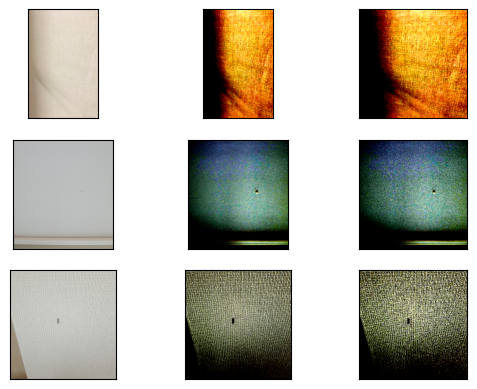

In [ ]:
# ========= 테스트 파일로 추론해보기 =========

# 데이콘 리더 보드 점수 => 모든 테스트 사진에 대하여 오염으로 판단하여 제출하지 않음

RESIZED_WIDTH = 240
RESIZED_HEIGHT = 240
MODEL_FILE_NAME = 'test2.h5'

# 추후에 라벨이 추가될 경우 등 확장성 및 모델의 안정성을 고려하여 총 19가지의 하자 유형의 순서가 변경되지 않도록 직접적으로 리스트 생성
DEFECT_TYPE_NAMES = ["가구수정", "걸레받이수정", "곰팡이", "꼬임", "녹오염", "들뜸", "면불량", "몰딩수정", "반점", "석고수정",
                     "오염", "오타공", "울음", "이음부불량", "창틀,문틀수정", "터짐", "틈새과다", "피스", "훼손"]

TEST_FOLDER_PATH ='/content/test'

test_img_paths = []
test_img_names = os.listdir(TEST_FOLDER_PATH)

for img_name in tqdm(test_img_names):

    img_path = os.path.join(TEST_FOLDER_PATH, img_name)
    test_img_paths.append(img_path)

# print('test_img_paths :', test_img_paths)

fig = plt.figure()

# 792개의 이미지 데이터
test_image_tensor = get_tensor_through_imgs_fn(test_img_paths, RESIZED_HEIGHT, RESIZED_WIDTH)
normalized_test_image_tensor = test_image_tensor / 255
print('normalized_test_image_tensor.shape :',
      normalized_test_image_tensor.shape)

model = load_model(MODEL_FILE_NAME)#custom_objects={"DropConnect":DropConnect}

predicted_y = model.predict(normalized_test_image_tensor)
print('predicted_y.shape :', predicted_y.shape)

predicted_index_list = np.argmax(predicted_y, axis=1)
# print('predicted_index_list :', predicted_index_list)

predicted_labels = []

for index in predicted_index_list:
    predicted_labels.append(DEFECT_TYPE_NAMES[index])

print('predicted_labels :', predicted_labels)

# 연월일_시간
now = datetime.today().strftime('%Y%m%d_%H%M%S')
predicted_csv = open(f'test_{now}.csv', 'w', newline='', encoding='utf-8')
wr = csv.writer(predicted_csv)
wr.writerow(['id', 'label'])

ids = []
predicted_label_count = len(predicted_labels)

for index in range(predicted_label_count):
    ids.append(f'TEST_{str(index).zfill(3)}')

# [ 'TEST_000', ... ]
# print('ids :', ids)

wr.writerows([*zip(ids, predicted_labels)])
predicted_csv.flush()
predicted_csv.close()

# ===========================================S

In [ ]:
result= pd.read_csv("/content/test_20230502_151200.csv")
result

,id,label
0,TEST_000,훼손
1,TEST_001,훼손
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손
...,...,...
787,TEST_787,훼손
788,TEST_788,훼손
789,TEST_789,훼손
790,TEST_790,훼손


In [ ]:
result['label'].value_counts()

훼손    792
Name: label, dtype: int64